# 3––Time Series Classification

* Univariate
* Multivariate

---
## Univariate time series classification

In univariate time series classification, we have a single time series variable and an associated label for multiple instances. The goal is to find a classifier that can learn the relationship between the time series and labels, and accurately predict the label of a new, unlabelled series. sktime provides time series classification algorithms and tools for building composite machine learning models.

<img src="../images/time-series-classification.png" width=1000/>


### The basic workflow

1. Specify data
1. Specify task: Which variable is the target variable, which ones are features?
1. Specify model
1. Fit
1. Predict

#### Data

To find other datasets, go to: http://timeseriesclassification.com/dataset.php

In [1]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sktime.datasets import load_UCR_UEA_dataset
from sktime.datatypes import convert

X, y = load_UCR_UEA_dataset("ItalyPowerDemand", return_X_y=True)
X = convert(X, from_type="nested_univ", to_type="numpy3D")

In [3]:
X.shape

(1096, 1, 24)

In [4]:
# binary target variable
np.unique(y)

array(['1', '2'], dtype='<U1')

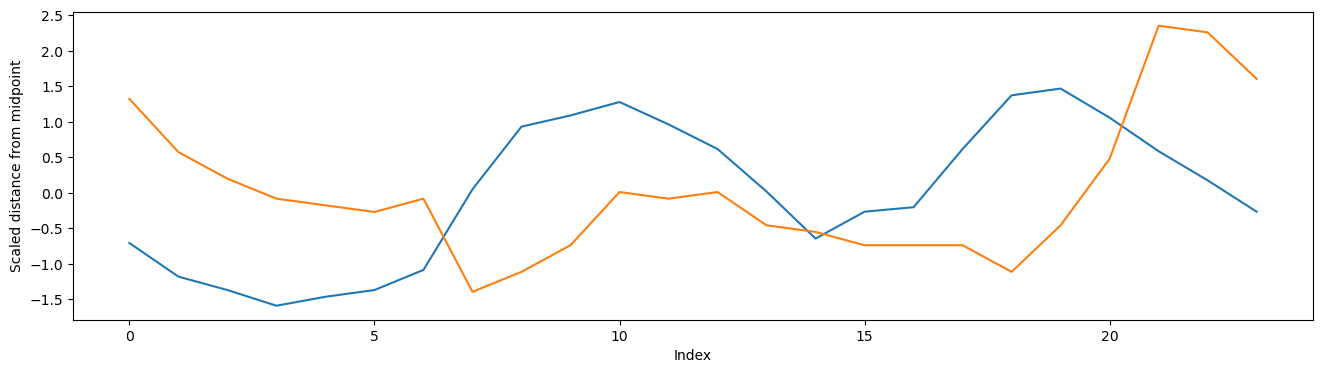

In [5]:
labels, counts = np.unique(y, return_counts=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for label in labels:
    ax.plot(X[y == label, 0, :][0], label=f"class {label}")
ax.set(ylabel="Scaled distance from midpoint", xlabel="Index");

#### Train-test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Model specification

Find out more about ROCKET:
* Repo: https://github.com/angus924/rocket
* Blog post: https://pub.towardsai.net/rocket-fast-and-accurate-time-series-classification-f54923ad0ac9

In [8]:
import sktime
sktime.__version__

'0.12.1'

In [11]:
from sktime.classification.kernel_based import RocketClassifier

classifier = RocketClassifier()

#### Fitting

In [12]:
%%time
classifier.fit(X_train, y_train)

CPU times: total: 1.27 s
Wall time: 2.33 s


RocketClassifier()

In [13]:
classifier.fit?

Signature: classifier.fit(X, y)
Docstring:
Fit time series classifier to training data.

Parameters
----------
X : 3D np.array (any number of dimensions, equal length series)
        of shape [n_instances, n_dimensions, series_length]
    or 2D np.array (univariate, equal length series)
        of shape [n_instances, series_length]
    or pd.DataFrame with each column a dimension, each cell a pd.Series
        (any number of dimensions, equal or unequal length series)
    or of any other supported Panel mtype
        for list of mtypes, see datatypes.SCITYPE_REGISTER
        for specifications, see examples/AA_datatypes_and_datasets.ipynb
y : 1D np.array of int, of shape [n_instances] - class labels for fitting
    indices correspond to instance indices in X

Returns
-------
self : Reference to self.

Notes
-----
Changes state by creating a fitted model that updates attributes
ending in "_" and sets is_fitted flag to True.
File:      c:\users\kojiro\miniconda3\envs\sktime-pydata\lib\si

#### Prediction

In [8]:
y_pred = classifier.predict(X_test)

#### Evaluation

In [9]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9708029197080292

### Classifiers in sktime

In [10]:
from sktime.registry import all_estimators

all_estimators("classifier", return_names=False)

/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'fbprophet'. 'fbprophet' is a soft dependency and not included in the sktime installation. Please run: `pip install fbprophet`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)
/Users/mloning/.conda/envs/sktime-pydata/lib/python3.8/site-packages/sktime/registry/_lookup.py:156: ImportWarning: No module named 'tbats'. 'tbats' is a soft dependency and not included in the sktime installation. Please run: `pip install tbats`. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(str(e), ImportWarning)


[sktime.classification.kernel_based._arsenal.Arsenal,
 sktime.classification.dictionary_based._boss.BOSSEnsemble,
 sktime.classification.interval_based._cif.CanonicalIntervalForest,
 sktime.classification.feature_based._catch22_classifier.Catch22Classifier,
 sktime.classification.hybrid._catch22_forest_classifier.Catch22ForestClassifier,
 sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier,
 sktime.classification.dictionary_based._cboss.ContractableBOSS,
 sktime.classification.interval_based._drcif.DrCIF,
 sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble,
 sktime.classification.hybrid._hivecote_v1.HIVECOTEV1,
 sktime.classification.hybrid._hivecote_v2.HIVECOTEV2,
 sktime.classification.dictionary_based._boss.IndividualBOSS,
 sktime.classification.dictionary_based._tde.IndividualTDE,
 sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier,
 sktime.classification.dictionary_based._muse.MUSE,
 sktime.classificat

### But can I not just use scikit-learn?

In principle, yes, but may not be as powerful as dedicated time series classification algorithms ...

See our previous tutorial from the PyData Amsterdam 2020 for more details: https://github.com/sktime/sktime-tutorial-pydata-amsterdam-2020
 
**Compare algorithms from sktime and scikit-learn!**

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.reduce import Tabularizer

classifier = make_pipeline(
    Tabularizer(), KNeighborsClassifier(n_neighbors=1, metric="euclidean")
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9635036496350365

### Advanced model building & composition

* Pipelining
* Ensembling
* Tuning
* Reduction

#### Pipelining

Check out the tsfresh package for automatic feature extraction: https://tsfresh.readthedocs.io/en/latest/

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [14]:
%%time
classifier = make_pipeline(
    TSFreshFeatureExtractor(disable_progressbar=True, show_warnings=False),
    RandomForestClassifier(),
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 4.27 s, sys: 268 ms, total: 4.54 s
Wall time: 34.9 s


0.9781021897810219

---
## Interlude: Time series regression

### Basic workflow

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import load_benzene_concentration_sample

Find out more about the dataset here: https://zenodo.org/record/3902673#.YXqxNy8w3UI

In [16]:
X, y = load_benzene_concentration_sample()
print(X.shape, y.shape)

(300, 1, 240) (300,)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

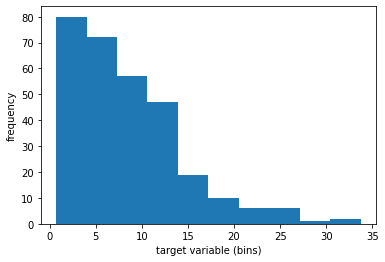

In [18]:
fig, ax = plt.subplots(1)
ax.hist(y)
ax.set(xlabel="target variable (bins)", ylabel="frequency");

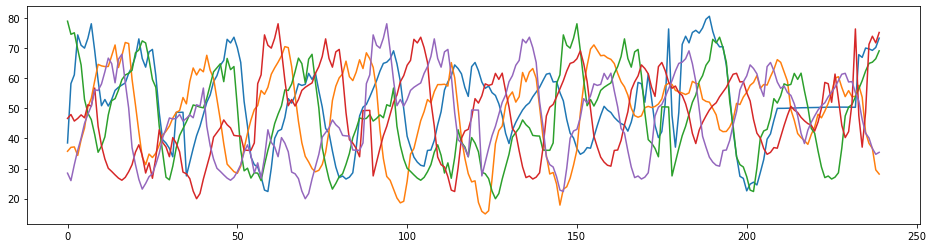

In [19]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(0.25))
for i in range(5):
    ax.plot(X_train[i, 0, :])

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

In [21]:
%%time
regressor = make_pipeline(Rocket(), RandomForestRegressor())
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

CPU times: user 1min 35s, sys: 88.8 ms, total: 1min 35s
Wall time: 1min 35s


17.267235331323448

### Reducing forecasting to time series regression
<img src="../images/forecasting-to-regression-reduction.png" width=500 align=right />

In [14]:
import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

y = load_airline()
fh = np.arange(12) + 1
y_train, y_test = temporal_train_test_split(y, fh=fh)

In [23]:
forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)

Look up the term "scitype" in our glossary: https://www.sktime.org/en/stable/glossary.html#term-Scientific-type

In [24]:
%%time
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender

pipe = TransformedTargetForecaster([("detrend", Detrender()), ("forecast", forecaster)])
pipe.fit(y_train)
y_pred = pipe.predict(fh)

CPU times: user 32.1 s, sys: 24.2 ms, total: 32.1 s
Wall time: 32.1 s


(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

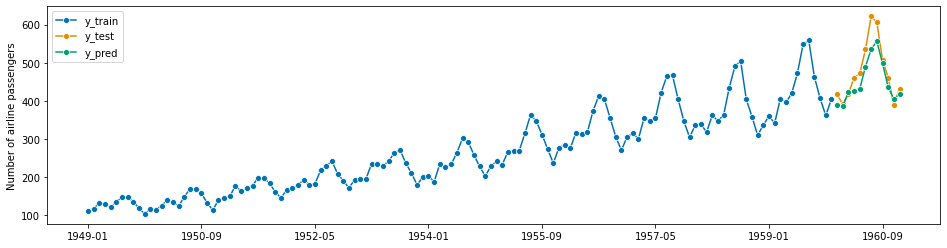

In [25]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

---
## Multivariate time series classification

In [26]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator

### Load multivariate time series/panel data

The [data set](http://www.timeseriesclassification.com/description.php?Dataset=BasicMotions) we use in this notebook was generated as part of a student project where four students performed four activities whilst wearing a smart watch. The watch collects 3D accelerometer and a 3D gyroscope It consists of four classes, which are walking, resting, running and badminton. Participants were required to record motion a total of five times, and the data is sampled once every tenth of a second, for a ten second period.

In [27]:
X, y = load_UCR_UEA_dataset("BasicMotions", return_X_y=True)
X = convert(X, from_type="nested_univ", to_type="numpy3D")

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 6, 100) (60,) (20, 6, 100) (20,)


In [28]:
# multi-class target variable
np.unique(y_train)

array(['badminton', 'running', 'standing', 'walking'], dtype=object)

## Multivariate classification
`sktime` offers three main ways of solving multivariate time series classification problems:

1. _Concatenation_ of time series columns into a single long time series column via `ColumnConcatenator` and apply a classifier to the concatenated data,
2. _Column-wise ensembling_ via `ColumnEnsembleClassifier` in which one classifier is fitted for each time series column and their predictions aggregated,
3. _Bespoke estimator-specific methods_ for handling multivariate time series data, e.g. finding shapelets in multidimensional spaces (still work in progress).

### Time series concatenation
We can concatenate multivariate time series/panel data into long univiariate time series/panel and then apply a classifier to the univariate data.

In [29]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", TimeSeriesForestClassifier(n_estimators=100)),
]
classifier = Pipeline(steps)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

1.0

### Column ensembling
We can also fit one classifier for each time series column and then aggregated their predictions. The interface is similar to the familiar `ColumnTransformer` from sklearn.

In [30]:
classifier = ColumnEnsembleClassifier(
    estimators=[
        ("TSF0", TimeSeriesForestClassifier(n_estimators=10), [0]),
        ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5), [3]),
    ]
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

1.0

### Bespoke classification algorithms
Another approach is to use bespoke (or classifier-specific) methods for multivariate time series data. Here, we try out the HIVE-COTE (version 2) algorithm in multidimensional space.

Check out the research paper: https://link.springer.com/article/10.1007%2Fs10994-021-06057-9

In [31]:
%%time
from sktime.classification.hybrid import HIVECOTEV2

X_train, y_train = load_UCR_UEA_dataset("BasicMotions", split="train", return_X_y=True)
X_test, y_test = load_UCR_UEA_dataset("BasicMotions", split="test", return_X_y=True)

classifier = HIVECOTEV2(
    stc_params={"n_shapelet_samples": 1000},
    drcif_params={"n_estimators": 25},
    arsenal_params={"n_estimators": 10},
    tde_params={"n_parameter_samples": 100},
    verbose=0,
)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

CPU times: user 2min 35s, sys: 658 ms, total: 2min 36s
Wall time: 1min 13s


1.0

---
## Building your own classifier

Check out our [classifier extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/classification.py)!

This is a Python file with to-do code blocks that allow you to implement your own, sktime-compatible classification algorithm.


---
## Summary

* univariate time series classification
* time series regression
* reduction: using time series regression for forecasting
* multivariate time series classification

### Useful resources

#### Research and benchmarking
* For time-series classification data sets and Java-based methods, check out [timeseriesclassification.com](http://www.timeseriesclassification.com)
* For a comparative benchmarking studies, check out 
    * [Bagnall, Anthony, et al. "The great time series classification bake off: a review and experimental evaluation of recent algorithmic advances." Data Mining and Knowledge Discovery 31.3 (2017): 606-660.](https://www.researchgate.net/profile/Anthony_Bagnall/publication/301856632_The_Great_Time_Series_Classification_Bake_Off_An_Experimental_Evaluation_of_Recently_Proposed_Algorithms_Extended_Version/links/579b580e08ae80bf6ea33d12.pdf) and 
    * [Fawaz, Hassan Ismail, et al. "Deep learning for time series classification: a review." Data Mining and Knowledge Discovery 33.4 (2019): 917-963.](https://arxiv.org/pdf/1809.04356)

#### Deep learning 
* For deep-learning, check out sktime's companion packages: [sktime-dl](https://github.com/sktime/sktime-dl)